# url: https://www.pymc.io/projects/examples/en/latest/howto/api_quickstart.html

## General API quickstart

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import pytensor.tensor as pt

In [2]:
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

## 1. Model creation

In [3]:
with pm.Model() as model:
    # Model definition
    pass

In [4]:
with pm.Model() as model:
    mu = pm.Normal("mu", mu=0, sigma=1)
    obs = pm.Normal("obs", mu=mu, sigma=1, observed=rng.standard_normal(100))

In [5]:
model.basic_RVs

[mu, obs]

In [6]:
model.free_RVs

[mu]

In [7]:
model.observed_RVs

[obs]

In [8]:
model.compile_logp()({"mu": 0})

array(-143.03962875)

In [9]:
%timeit model.compile_logp()({"mu": 0.1})
logp = model.compile_logp()
%timeit logp({"mu": 0.1})

133 ms ± 24 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
18.2 µs ± 3.2 µs per loop (mean ± std. dev. of 7 runs, 100000 loops each)


## 2. Probability Distributions

## Unobserved Random Variables

In [10]:
with pm.Model():
    x = pm.Normal("x", mu=0, sigma=1)

In [11]:
pm.logp(x, 0).eval()

array(-0.91893853)

## Observed Random Variables

In [12]:
with pm.Model():
    obs = pm.Normal("x", mu=0, sigma=1, observed=rng.standard_normal(100))

## Deterministic transforms

In [13]:
with pm.Model():
    x = pm.Normal("x", mu=0, sigma=1)
    y = pm.Gamma("y", alpha=1, beta=1)
    plus_2 = x + 2
    summed = x + y
    squared = x**2
    sined = pm.math.sin(x)

In [14]:
with pm.Model():
    x = pm.Normal("x", mu=0, sigma=1)
    plus_2 = pm.Deterministic("x plus 2", x + 2)

## Lists of RVs / higher-dimensional RVs

In [15]:
with pm.Model():
    # bad:
    x = [pm.Normal(f"x_{i}", mu=0, sigma=1) for i in range(10)]

In [16]:
coords = {"cities": ["Santiago", "Mumbai", "Tokyo"]}
with pm.Model(coords=coords) as model:
    # good:
    x = pm.Normal("x", mu=0, sigma=1, dims="cities")

In [17]:
with model:
    y = x[0] * x[1]  # indexing is supported
    x.dot(x.T)  # linear algebra is supported

## Initialize Random Variables

In [18]:
with pm.Model(coords={"idx": np.arange(5)}) as model:
    x = pm.Normal("x", mu=0, sigma=1, dims="idx")

model.initial_point()

{'x': array([0., 0., 0., 0., 0.])}

In [19]:
with pm.Model(coords={"idx": np.arange(5)}) as model:
    x = pm.Normal("x", mu=0, sigma=1, dims="idx", initval=rng.standard_normal(5))

model.initial_point()

{'x': array([-0.36012097, -0.16168135,  1.07485641, -0.08855632, -0.03857412])}

## 3. Inference

## 3.1 Sampling

In [20]:
with pm.Model() as model:
    mu = pm.Normal("mu", mu=0, sigma=1)
    obs = pm.Normal("obs", mu=mu, sigma=1, observed=rng.standard_normal(100))

    idata = pm.sample(2000)

In [21]:
idata.posterior.dims

Frozen({'chain': 2, 'draw': 2000})

In [22]:
with pm.Model() as model:
    mu = pm.Normal("mu", mu=0, sigma=1)
    obs = pm.Normal("obs", mu=mu, sigma=1, observed=rng.standard_normal(100))

    idata = pm.sample(cores=4, chains=6)

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


In [23]:
idata.posterior["mu"].shape

(6, 1000)

In [24]:
# get values of a single chain
idata.posterior["mu"].sel(chain=2).shape

(1000,)

## 3.2 Analyze sampling results

In [25]:
with pm.Model() as model:
    mu = pm.Normal("mu", mu=0, sigma=1)
    sd = pm.HalfNormal("sd", sigma=1)
    obs = pm.Normal("obs", mu=mu, sigma=sd, observed=rng.standard_normal(100))

    idata = pm.sample()

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


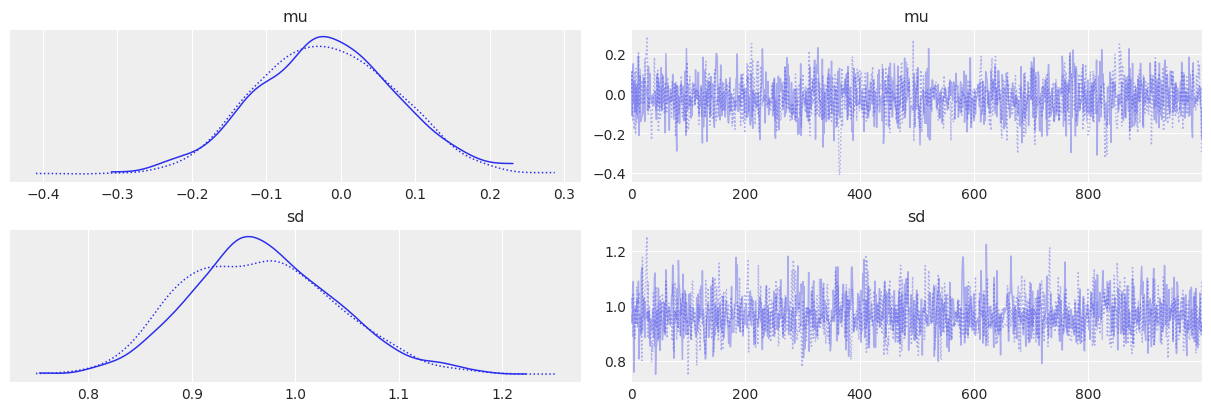

In [26]:
az.plot_trace(idata);

In [27]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,-0.021,0.095,-0.193,0.161,0.002,0.002,1657.0,1173.0,1.0
sd,0.968,0.073,0.839,1.104,0.002,0.001,1652.0,1459.0,1.0


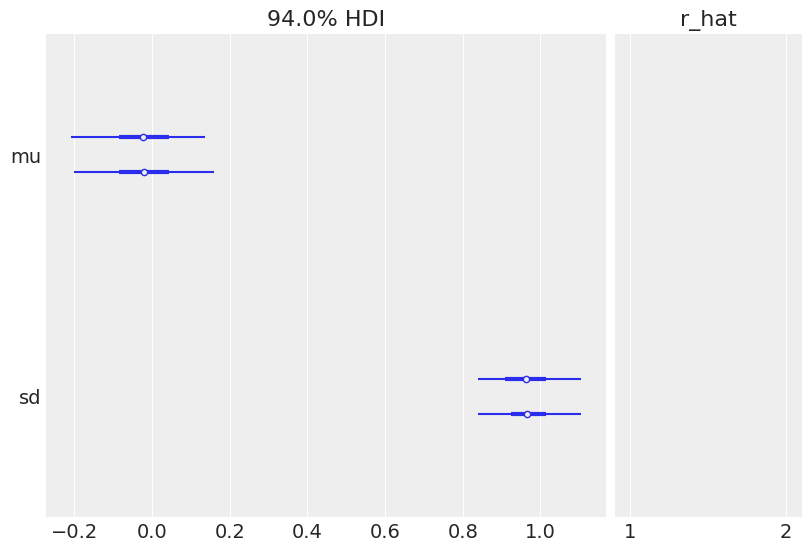

In [28]:
az.plot_forest(idata, r_hat=True);

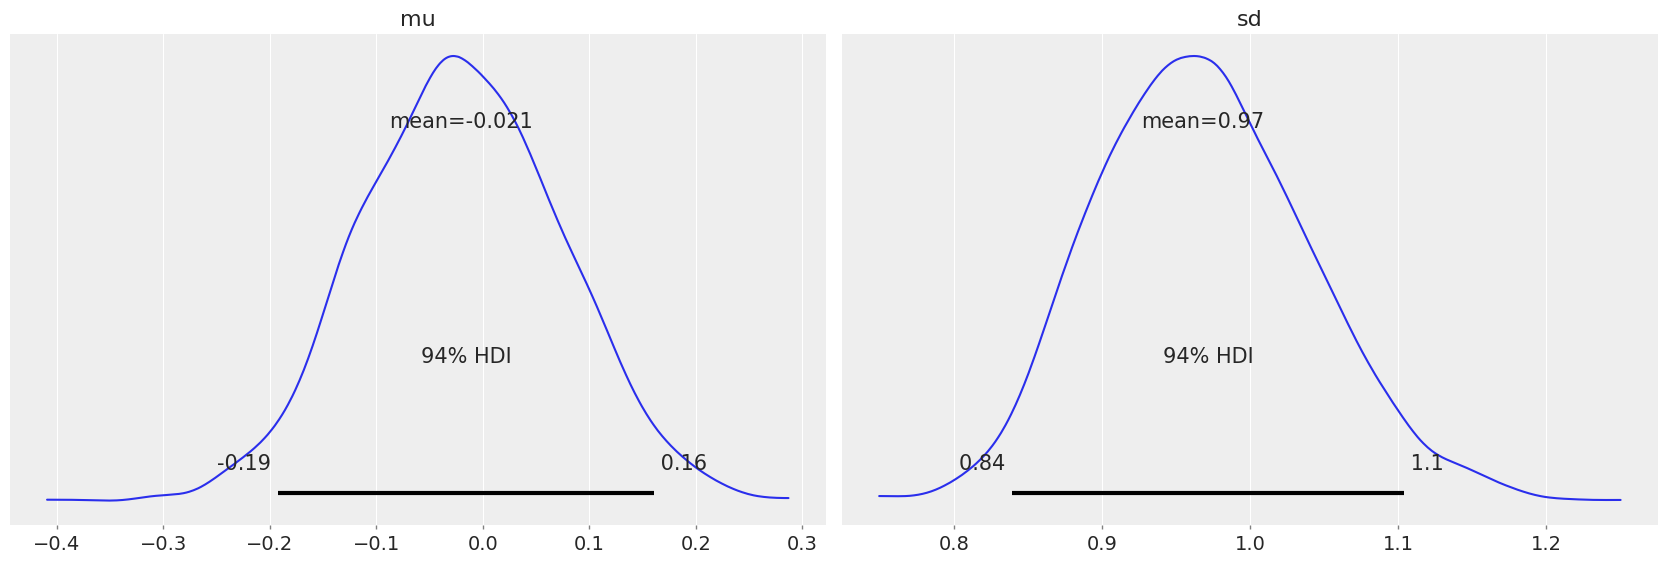

In [29]:
az.plot_posterior(idata);

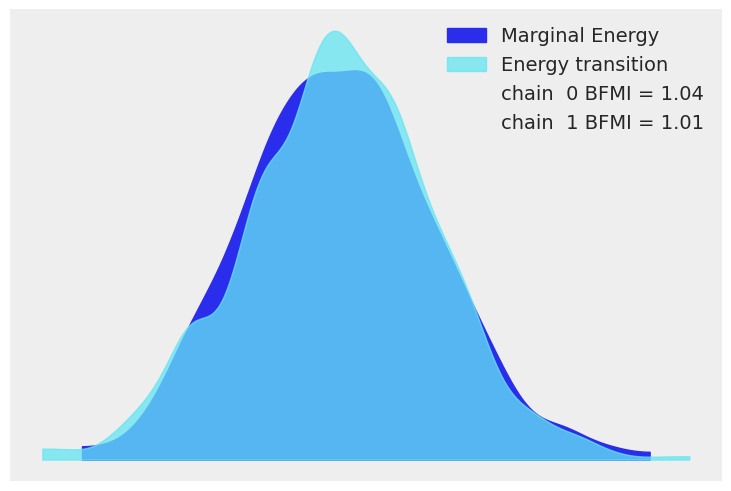

In [30]:
with pm.Model(coords={"idx": np.arange(100)}) as model:
    x = pm.Normal("x", mu=0, sigma=1, dims="idx")
    idata = pm.sample()

az.plot_energy(idata);

## 3.3 Variational inference

In [31]:
with pm.Model() as model:
    mu = pm.Normal("mu", mu=0, sigma=1)
    sd = pm.HalfNormal("sd", sigma=1)
    obs = pm.Normal("obs", mu=mu, sigma=sd, observed=rng.standard_normal(100))

    approx = pm.fit()

In [32]:
idata = approx.sample(1000)
az.summary(idata)

Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,-0.036,0.171,-0.334,0.294,0.005,0.004,1012.0,905.0,NaN
sd,0.990,0.151,0.739,1.289,0.005,0.003,984.0,874.0,NaN


In [33]:
mu = pm.floatX([0.0, 0.0])
cov = pm.floatX([[1, 0.5], [0.5, 1.0]])
with pm.Model(coords={"idx": np.arange(2)}) as model:
    pm.MvNormal("x", mu=mu, cov=cov, dims="idx")
    approx = pm.fit(method="fullrank_advi")

In [34]:
with pm.Model(coords={"idx": np.arange(2)}) as model:
    pm.MvNormal("x", mu=mu, cov=cov, dims="idx")
    approx = pm.FullRankADVI().fit()

In [35]:
with pm.Model(coords={"idx": np.arange(2)}) as model:
    pm.MvNormal("x", mu=mu, cov=cov, dims="idx")
    approx = pm.FullRankADVI().fit()

<Figure size 720x480 with 0 Axes>

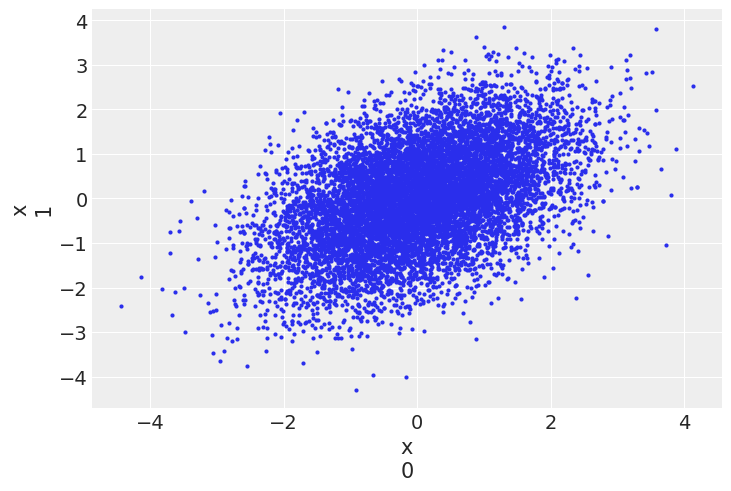

In [36]:
plt.figure()
idata = approx.sample(10000)
az.plot_pair(idata, var_names="x", coords={"idx": [0, 1]});

In [37]:
w = pm.floatX([0.2, 0.8])
mu = pm.floatX([-0.3, 0.5])
sd = pm.floatX([0.1, 0.1])
with pm.Model() as model:
    pm.NormalMixture("x", w=w, mu=mu, sigma=sd)
    approx = pm.fit(method=pm.SVGD(n_particles=200, jitter=1.0))

In [38]:
with pm.Model() as model:
    pm.NormalMixture("x", w=[0.2, 0.8], mu=[-0.3, 0.5], sigma=[0.1, 0.1])

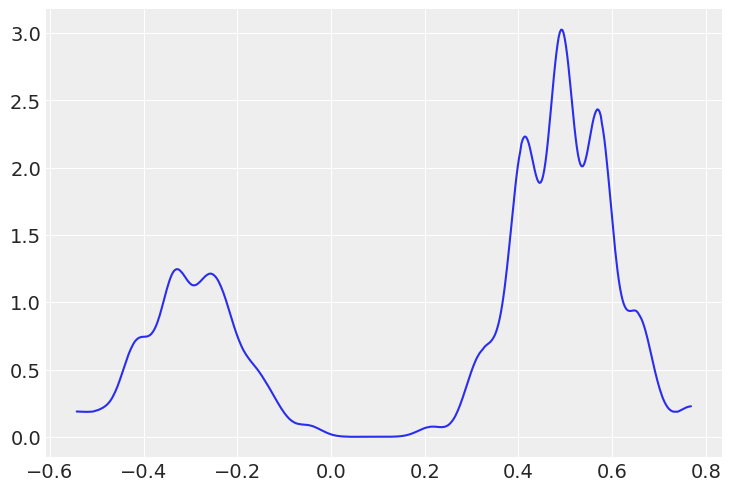

In [39]:
plt.figure()
idata = approx.sample(10000)
az.plot_dist(idata.posterior["x"]);

## 4. Posterior Predictive Sampling

In [40]:
data = rng.standard_normal(100)
with pm.Model() as model:
    mu = pm.Normal("mu", mu=0, sigma=1)
    sd = pm.HalfNormal("sd", sigma=1)
    obs = pm.Normal("obs", mu=mu, sigma=sd, observed=data)

    idata = pm.sample()

In [41]:
with model:
    idata.extend(pm.sample_posterior_predictive(idata))

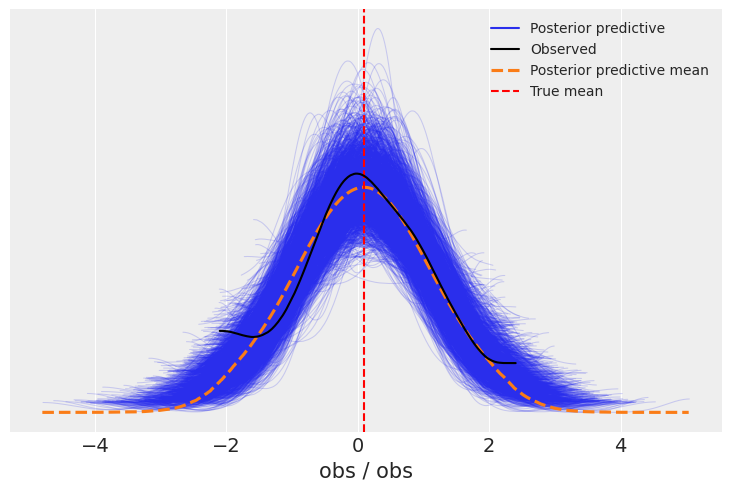

In [42]:
fig, ax = plt.subplots()
az.plot_ppc(idata, ax=ax)
ax.axvline(data.mean(), ls="--", color="r", label="True mean")
ax.legend(fontsize=10);

## 4.1 Predicting on hold-out data

In [43]:
x = rng.standard_normal(100)
y = x > 0

coords = {"idx": np.arange(100)}
with pm.Model() as model:
    # create shared variables that can be changed later on
    x_obs = pm.MutableData("x_obs", x, dims="idx")
    y_obs = pm.MutableData("y_obs", y, dims="idx")

    coeff = pm.Normal("x", mu=0, sigma=1)
    logistic = pm.math.sigmoid(coeff * x_obs)
    pm.Bernoulli("obs", p=logistic, observed=y_obs, dims="idx")
    idata = pm.sample()

In [44]:
with model:
    # change the value and shape of the data
    pm.set_data(
        {
            "x_obs": [-1, 0, 1.0],
            # use dummy values with the same shape:
            "y_obs": [0, 0, 0],
        },
        coords={"idx": [1001, 1002, 1003]},
    )

    idata.extend(pm.sample_posterior_predictive(idata))

In [45]:
idata.posterior_predictive["obs"].mean(dim=["draw", "chain"])

<xarray.DataArray 'obs' (idx: 3)>
array([0.0225, 0.4715, 0.974 ])
Coordinates:
  * idx      (idx) int64 1001 1002 1003

In [46]:
!pip install watermark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 8.6 MB/s eta 0:00:00


In [47]:
%load_ext watermark

%watermark -n -u -v -iv -w -p pytensor

Last updated: Fri Dec 15 2023

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 7.34.0

pytensor: 2.14.2

numpy     : 1.23.5
pytensor  : 2.14.2
arviz     : 0.15.1
matplotlib: 3.7.1
pymc      : 5.7.2

Watermark: 2.4.3

